### import packages

In [90]:
import numpy as np
import subprocess
from pathlib import Path
import os
import open3d as o3d
import vedo
import shutil
import json
import importlib
import sys
from PIL import Image
import trimesh
from tabulate import tabulate
import copy

### Set Output Path

In [91]:
output_path = r"c:/Users/Tobias/Documents/Masterarbeit_lokal/synthetic_pipeline/meshroom_data/static_Dodekaeder_30cam"

### loading reconstructed data

In [92]:
# Define the evaluation_path by combining the output_path and "Evaluation" directory
evaluation_path = Path(output_path) / "Evaluation"
# Initialize an empty dictionary to store the read variables
variables = {}
# Open the cache.txt file located in the evaluation_path directory in read mode
with open((evaluation_path / "cache.txt"), 'r') as cache_file:
    # Iterate through each line in the file
    for line in cache_file:
        # Split each line by the colon ':' to separate variable name and value
        name, value = line.strip().split(":", 1)
        # Add the variable name and value pair to the variables dictionary after stripping whitespace
        variables[name.strip()] = value.strip()
# Access the read variables from the dictionary
project_name = variables.get("project_name", "")
output_path = variables.get("output_path", "")
image_dir = variables.get("image_dir", "")
obj_path = variables.get("obj_path", "")
# Print out the read variables
print("Read Variables:")
print("Project Name:", project_name)
print("Output Path:", output_path)
print("Image Directory:", image_dir)
print("OBJ Path:", obj_path)

Read Variables:
Project Name: static_Dodekaeder_30cam
Output Path: c:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\meshroom_data\static_Dodekaeder_30cam
Image Directory: C:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\blender_data\static_Dodekaeder_30cam
OBJ Path: C:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\objects\Dodekaeder\Mesh-Dateien\Wuerfel_12s\centered\12s.obj


#### plot reconstructed mesh

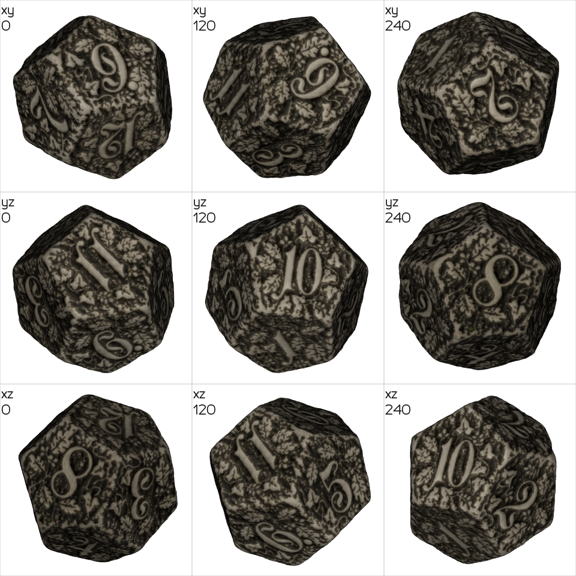

In [93]:
importlib.reload(sys.modules['src.plot_mesh_vedo']) if 'src.plot_mesh_vedo' in sys.modules else None
from src.plot_mesh_vedo import plot_mesh_vedo
fig,screenshot_path = plot_mesh_vedo(project_name,evaluation_path)
img = Image.open(screenshot_path)
scale = 0.6
display(img.resize(( int(img.width * scale), int(img.height * scale))))

#### Scaling factor

In [94]:
importlib.reload(sys.modules['src.scaling_factor']) if 'src.scaling_factor' in sys.modules else None
from src.scaling_factor import scaling_factor
factor_mean, factor_median, factor_std, cam_pos_rec, cam_pos_blender, fig = scaling_factor(output_path,image_dir,evaluation_path) # approximate scaling factor 

scaling = factor_median             # Set the scaling factor
T_scale = np.eye(4)                 # Initialize a 4x4 identity matrix for the transformation matrix
for i in range(3):                  # Iterate over the first 3 diagonal elements of the matrix and set them to the scaling factor
    T_scale[i,i] = scaling

c:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\src\scaling_factor.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


### Alignment of the reconstructed mesh with the ground truth

In [95]:
# Define file path to the mesh files
mesh_gt_path = obj_path                                                   # Path to ground truth mesh
mesh_r_path = evaluation_path / 'texturedMesh.obj'                        # Path to reconstructed mesh

#### Global Registration using open3d / Feature based alignment

In [96]:
AutomatedGlobalRegistration = True
if AutomatedGlobalRegistration == True:
    importlib.reload(sys.modules['src.GlobalMeshRegistration']) if 'src.GlobalMeshRegistration' in sys.modules else None
    from src.GlobalMeshRegistration import GlobalMeshRegistration
    voxel_size = 1*10**(-3)
    draw_registration = 3 # choose 0,1,2,3 --> 0 = no plot appears --> 3 = all plots appears
    T_global = GlobalMeshRegistration(mesh_r_path,mesh_gt_path,voxel_size,draw_registration,T_scale)

    T_global_path = evaluation_path / 'GlobalTransformationMatrix.txt'    # Define the file path for the saved transformation matrix
    np.savetxt(T_global_path,T_global)
else: #Do It manually
    T_global_path = evaluation_path / 'GlobalTransformationMatrix_manual.txt'    # Define the file path for the saved transformation matrix
    T_global = np.loadtxt(T_global_path)
    # 1.) open CloudCompare
    # 2.) load texturedMesh (reconstructed) and the ground truth mesh (centered) 
    # 3.) deactivate normals on the ground truth mesh under Properties -> CC Object -> Normals
    # 4.) select both meshes by holding the control button. Important: First, select the ground truth mesh and then the reconstructed mesh 
    # 5.) scale the reconstructed mesh with the calculated scaling factor:
    #       - select the texturedMesh and go to edit -> Multiply/Scale --> enter the scaling factor and press Ok
    # 6.) Rotate the reconstructed Mesh (texturedMesh) with the Translate/Rotate Function in the top bar
    #   a) switch back and forth between the visibility of the objects and memorize distinctive spots on the ground truth mesh
    #   b) select the texturedMesh and use the Translate/Rotate Function
    #   c) rotate the texturedMesh so that the two meshes lie approximately on top of each other 
    # 7.) Finely Register the two Meshes
    #    a) select both meshes, click on the Finely Register Button on the top bar
    #    b) swap the meshes, if texturedMesh is not the "to be aligned"-Mesh
    #    c) click okay (disable adjust scale)
    # 8.) Export the Transformation Matrix
    #   a) select the texturedMesh.registered and export the transformation history under Properties --> Transformation history --> Export --> ASCII   
    #   b) save the File under "/../Evaluation/GlobalTransformationMatrix_manual.txt" 
    # 9.) Save the Registration inside a CloudCompare file 



:: Downsample with a voxel size 0.001.
:: Estimate normal with search radius 0.002.
:: Compute FPFH feature with search radius 0.005.
:: Downsample with a voxel size 0.001.
:: Estimate normal with search radius 0.002.
:: Compute FPFH feature with search radius 0.005.
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.001,
   we use a liberal distance threshold 0.002.
RegistrationResult with fitness=1.000000e+00, inlier_rmse=6.526676e-04, and correspondence_set size of 1911
Access transformation to get result.


#### Fine Registration using CloudCompare / Iterative Closest Point (ICP) algorithm

In [97]:
# Set parameters
save_meshes_all_at_once = False                 # Save the transformed reconstructed mesh with the Groud_truth mesh in a single file (uses a lot of hard disk space)
silent = True                                   # No GUI pops up and no clicks necessary
adjust_scale = True                            # Alignment of the Mesh with SCALING
# Define output format for meshes
output_format_mesh = "OBJ"                                              # Format can be one of the following: BIN, OBJ, PLY, STL, VTK, MA, FBX.

# Function to align the reconstruected mesh and to calculate the Mesh to Mesh distance
importlib.reload(sys.modules['src.FineMeshRegistration_and_MeshToMeshDistance']) if 'src.FineMeshRegistration_and_MeshToMeshDistance' in sys.modules else None
from src.FineMeshRegistration_and_MeshToMeshDistance import FineMeshRegistration_and_MeshToMeshDistance
params_CC = [silent,save_meshes_all_at_once,adjust_scale,output_format_mesh]
T,T_ICP,mesh_r_trans_path,log_path = FineMeshRegistration_and_MeshToMeshDistance(params_CC,evaluation_path,mesh_gt_path,mesh_r_path,output_format_mesh,T_global_path)

In [98]:
matrix = T_ICP
s_x = np.linalg.norm(matrix[:, 0])  # Length of the first column vector
s_y = np.linalg.norm(matrix[:, 1])  # Length of the second column vector
s_z = np.linalg.norm(matrix[:, 2])  # Length of the third column vector

print("Scaling in X direction:", s_x)
print("Scaling in Y direction:", s_y)
print("Scaling in Z direction:", s_z)
print("Scaling factor:", scaling)
print("Scaling factor by CC:", scaling*np.mean([s_x,s_y,s_z]))

Scaling in X direction: 0.9545379018021778
Scaling in Y direction: 0.9545379038539756
Scaling in Z direction: 0.954537889957697
Scaling factor: 0.20000733340898796
Scaling factor by CC: 0.19091457972439452


### Cloud to Mesh: Mean Distance and Standard Deviation

In [99]:
# Reload the module 'read_c2m_distance_from_log' if it's already imported
importlib.reload(sys.modules['src.read_c2m_distance_from_log']) if 'src.read_c2m_distance_from_log' in sys.modules else None
from src.read_c2m_distance_from_log import read_c2m_distance_from_log
# Call the function to read mean distance and standard deviation from the log file
mean_distance, std_deviation = read_c2m_distance_from_log(log_path)

Cloud to Mesh Distance:
----------------------------------------
Global Mesh Registration
Mean distance: 0.000446072, Standard deviation: 0.000260215
--------------------
Closest Point Registration Procedure (ICP)
Mean distance: 3.87998e-06, Standard deviation: 0.000143492


### Comparison of volumes and surfaces

In [100]:
# Load reconstructed mesh and apply transformation (scaling factor)
tri_mesh_r = trimesh.load_mesh(evaluation_path / "texturedMesh.obj")
tri_mesh_r_cc = copy.deepcopy(tri_mesh_r)
tri_mesh_r.apply_transform(T_global)
tri_mesh_r_cc.apply_transform(T) 

# Load ground truth mesh
tri_mesh_gt = trimesh.load_mesh(mesh_gt_path)

# calculate volume
volume_r = tri_mesh_r.volume
volume_gt = tri_mesh_gt.volume
volume_r_cc = tri_mesh_r_cc.volume
# calculate surface area
surface_area_r = tri_mesh_r.area
surface_area_gt = tri_mesh_gt.area
surface_area_r_cc = tri_mesh_r_cc.area
# calculate sauter diameter
sauter_diameter_r = 6 * volume_r / surface_area_r
sauter_diameter_gt = 6 * volume_gt / surface_area_gt
sauter_diameter_r_cc = 6 * volume_r_cc / surface_area_r_cc
# Define the data as a list of lists
data = [
    ["Reconstructed Obj.", volume_r, surface_area_r, sauter_diameter_r*1000],
    ["Reconstructed Obj. (Scaling by CloudCompare)", volume_r_cc, surface_area_r_cc, sauter_diameter_r_cc*1000],
    ["Ground Truth", volume_gt, surface_area_gt, sauter_diameter_gt*1000]
]
# Define the headers with units
headers = ["Object", f"Volume (m^3)", f"Surface Area (m^2)", f"Sauter Diameter (mm)"]
# Print the data as a table
print(tabulate(data, headers=headers))

Object                                          Volume (m^3)    Surface Area (m^2)    Sauter Diameter (mm)
--------------------------------------------  --------------  --------------------  ----------------------
Reconstructed Obj.                               4.76558e-06            0.00147086                 19.44
Reconstructed Obj. (Scaling by CloudCompare)     4.14472e-06            0.00134017                 18.5562
Ground Truth                                     4.14541e-06            0.00136192                 18.2627


In [101]:
importlib.reload(sys.modules['src.cam_TransMatrix']) if 'src.cam_TransMatrix' in sys.modules else None
from src.cam_TransMatrix import cam_TransMatrix_ExpBlender

importlib.reload(sys.modules['src.camera_pose_visualizer']) if 'src.camera_pose_visualizer' in sys.modules else None
from src.camera_pose_visualizer import CameraPoseVisualizer

focal_length = 16*10**(-3)
sensor_width = 7.12*10**(-3)
aspect_ratio = 7.12/5.33
scale = 2
visualizer = CameraPoseVisualizer([-0.15, 0.15], [-0.15, 0.15], [0.85, 1.15])
for i in range(len(cam_pos_blender)):
    cam = cam_pos_blender.iloc[i]
    if cam["TimeStep"] == 1:
        x = cam["PositionX"]; y = cam["PositionY"]; z = cam["PositionZ"]
        theta_x = cam["RotationEulerX"]; theta_y = cam["RotationEulerY"]; theta_z = cam["RotationEulerZ"]
        T_cam =  cam_TransMatrix_ExpBlender(x,y,z,theta_x,theta_y,theta_z)
        if z == 1:
            visualizer.extrinsic2pyramid(T_cam, 'b', focal_length,aspect_ratio,sensor_width,scale)
        elif z > 1:
            visualizer.extrinsic2pyramid(T_cam, 'r', focal_length,aspect_ratio,sensor_width,scale)
        else:
            visualizer.extrinsic2pyramid(T_cam, 'g', focal_length,aspect_ratio,sensor_width,scale)
    else: 
        break  
visualizer.create_cube(position=[0,0,1.2],size=0.03,color='k',alpha=0.4,rotation=[15,0,15])   # size=a=b=c
visualizer.create_cube(position=[0,0,1.05],size=0.03,color='k',alpha=0.3,rotation=[30,0,30])
visualizer.create_cube(position=[0,0,0.95],size=0.03,color='k',alpha=0.2,rotation=[45,0,45])
visualizer.create_cube(position=[0,0,0.8],size=0.03,color='k',alpha=0.1,rotation=[60,0,-60])
#%matplotlib inline
%matplotlib qt
title = 'Extrinsic Camera Parameter (Ground Truth)'
visualizer.show()
path = evaluation_path / "Extrinsics_Cams_GT"
visualizer.save(path)

c:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\src\camera_pose_visualizer.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


initialize camera pose visualizer
